In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
import pyvista as pv
import imageio
from pypfm import PFMLoader
np.set_printoptions(formatter={"float": "{:10.2f}".format})

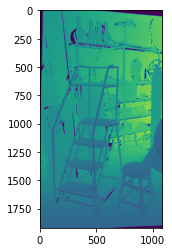

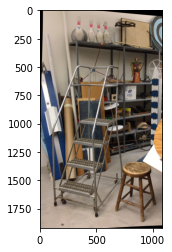

In [3]:
img_path = "/home/julian/data/middlebury/all/data/ladder1/im0.png"
dispm_path = "/home/julian/data/middlebury/all/data/ladder1/disp0.pfm"
f = 1733.68
cam = np.array([[f, 0, 819.72], [0, f, 957.55], [0, 0, 1]])
baseline=221.13
doffs=0

loader = PFMLoader(color=False, compress=False)
pfm = loader.load_pfm(dispm_path)

for y in range(pfm.shape[0]):
    for x in range(pfm.shape[1]):
        disp = pfm[y,x]
        Z = baseline * f / (disp + doffs)
        pfm[y,x] = Z

dm = np.flip(pfm,axis=0)

im = imageio.imread(img_path)
im = np.asarray(im)

plt.figure()
plt.imshow(dm,origin="upper")

plt.figure()
plt.imshow(im)


In [4]:
pts = []
invK = la.inv(cam)
for y in range(dm.shape[0]):
    for x in range(dm.shape[1]):
        dist = dm[y,x]
        pt = dist * (invK @ [x,y,1])
        pts.append(pt)

pts = np.array(pts)

In [5]:
#mesh['colors'] = my_rgb_array
#mesh.plot(scalars='colors', rgb=True, notebook=False)

mesh = pv.PolyData(pts)
mesh['colors'] = np.reshape(im,(-1,3))

#mesh.plot(scalars='colors',rgb=True, render_points_as_spheres=True,eye_dome_lighting=True,notebook=False)
mesh.plot(scalars='colors',rgb=True,notebook=False, eye_dome_lighting=True)

In [68]:
from src.dmcpworkflow.annotate_points import annotate

%matplotlib
cps = annotate(im[:,:,0],dm) # exactly nonplanar 6 do seem best
%matplotlib inline
print(cps)

Using matplotlib backend: TkAgg
[[    141.57     863.05     138.99     870.81]]


In [55]:
#cps[:,2:] = cps[:,:2]

In [6]:
#cps = np.array([[ 340.53626943,  498.71808761,  340.53626943,  498.71808761],
#       [ 441.31010699,  514.22175493,  441.31010699,  514.22175493],
#       [ 689.36878407,  506.46992127,  689.36878407,  506.46992127],
#       [ 619.60228114,  496.13414306,  619.60228114,  496.13414306],
#       [ 131.23676065, 1568.47113249,  131.23676065, 1568.47113249],
#       [ 492.98899805, 1661.4931364 ,  492.98899805, 1661.4931364 ],
#       [ 418.05460602, 1436.6899603 ,  418.05460602, 1436.6899603 ],
#       [ 715.20822959, 1488.36885136,  715.20822959, 1488.36885136]])

cps = np.array([[    702.29,    1677.00   ,  704.87  ,  1679.58],
 [    898.67  ,  1757.10   ,  898.67 ,   1754.52],
 [   1002.03,    1674.41 ,    994.27  ,  1664.08],
 [    968.43 ,   1540.05,     968.43  ,  1545.22],
 [    890.92 ,   1586.56,     885.75   , 1583.97],
 [    735.88 ,   1532.30   ,  738.46   , 1534.88],
 [    141.57 ,    863.05   ,  138.99  ,   870.81]])

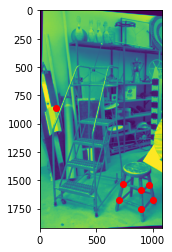

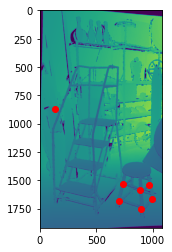

In [7]:
plt.figure()
plt.imshow(im[:,:,0])
plt.scatter(cps[:,0],cps[:,1],c="r")

plt.figure()
plt.imshow(dm,origin="upper")
plt.scatter(cps[:,2],cps[:,3],c="r")

plt.show()

In [8]:
from src.pycv.dmcp import dm_to_world
ext = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0]])
P = cam @ ext

world_pts = dm_to_world(dm, cam, P,cps[:,2:])
world_pts

array([[   -445.46,    2800.50,    6724.33],
       [    285.14,    2878.36,    6261.40],
       [    709.31,    2871.07,    7045.02],
       [    593.91,    2347.00,    6923.86],
       [    238.58,    2263.38,    6264.12],
       [   -311.06,    2209.99,    6636.44],
       [  -3597.33,    -458.38,    9161.65]], dtype=float32)

In [9]:
import pyvista as pv
cps_mesh = pv.PolyData(world_pts)
pl = pv.Plotter(off_screen=False,notebook=False)
pl.add_mesh(mesh, scalars="colors",rgb=True)
pl.add_mesh(cps_mesh, color="red", point_size=25, render_points_as_spheres=True)
pl.show()

In [10]:
from src.pycv.dmcp import dmcp
R  = np.array([ [ 0.6663311,  0.2944014,  0.6850771],
   [0.6567611,  0.2033320, -0.7261687],
  [-0.3530832,  0.9338008, -0.0578650 ]])
T = np.array([[100,100,-200]]).T
trans = np.hstack((R,T))
trans = np.vstack((trans,[0,0,0,1]))

P_im = P @ la.inv(trans)

#P_im = P

A = dmcp(cam, P_im, cps[:,:2],world_pts)
print(f"A\n{A}")

estimated pose
[[     -0.98       0.07       0.19    1650.54]
 [      0.10      -0.64       0.76    6531.74]
 [      0.18       0.76       0.62   13785.62]]
A
[[     -0.50      -0.76       0.40    1858.00]
 [      0.40      -0.62      -0.68    6418.21]
 [      0.77      -0.18       0.61   13849.46]
 [      0.00       0.00       0.00       1.00]]


In [11]:
P_trans = P_im @ la.inv(A)

print("pose (mm)")
pos_est = la.null_space(P_trans) / la.null_space(P_trans)[-1]
pos_truth = la.null_space(P) / la.null_space(P)[-1]

pos_est = pos_est[:3].flatten()
pos_truth = pos_truth[:3].flatten()
pos_est 

pose (mm)


array([   1650.54,    6531.74,   13785.62])

dmcp works with arbitrary transformation 

In [12]:
sv_est = pv.Sphere(center=pos_est,radius=500)
sv_gt = pv.Sphere(center=pos_truth,radius= 500)
pl = pv.Plotter(off_screen=False,notebook=False)
pl.add_mesh(mesh, scalars="colors",rgb=True)
pl.add_mesh(sv_gt, color="green")
pl.add_mesh(sv_est, color="blue")
pl.show()

reproject points

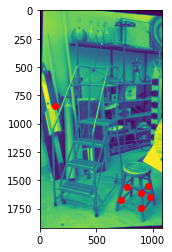

In [19]:
#P_trans @ world_pts
reprojected = P_trans @ np.hstack((world_pts,np.ones((world_pts.shape[0],1)))).T
reprojected = reprojected.T
repr0 = reprojected[:,0] / reprojected[:,-1]
repr1 = reprojected[:,1] / reprojected[:,-1]
repr = np.vstack((repr0,repr1)).T

plt.imshow(im[:,:,0])
plt.scatter(repr[:,0],repr[:,1], c="r")

#### test the same for custom depth map

In [21]:
from src.dmcpworkflow.capture_depth import generate_depth_map

tup = generate_depth_map(mesh)

[[   1196.27       0.00     512.00]
 [      0.00     897.20     384.00]
 [      0.00       0.00       1.00]]


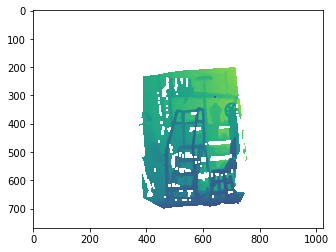

In [22]:
_dm, _dmK, _dmP = tup

print(_dmK)

plt.imshow(_dm)
plt.show()

In [24]:
from src.dmcpworkflow.annotate_points import annotate
%matplotlib
_cps = annotate(im[:,:,0],_dm) # exactly nonplanar 6 do seem best
%matplotlib inline
print(_cps)

Using matplotlib backend: TkAgg
[[    697.12    1666.66     629.87     647.31]
 [    901.25    1757.10     680.79     648.69]
 [   1002.03    1669.24     719.33     650.06]
 [    976.19    1529.71     708.32     612.90]
 [    898.67    1586.56     680.79     604.64]
 [    730.71    1521.96     639.50     604.64]
 [    358.62      80.12     492.23     245.42]]


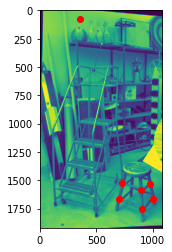

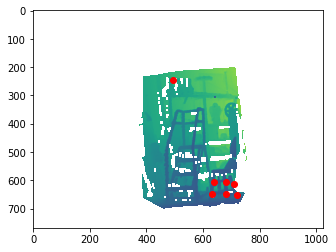

In [25]:
plt.figure()
plt.imshow(im[:,:,0])
plt.scatter(_cps[:,0],_cps[:,1],c="r")

plt.figure()
plt.imshow(_dm,origin="upper")
plt.scatter(_cps[:,2],_cps[:,3],c="r")

plt.show()

In [26]:
_world_pts = dm_to_world(_dm, _dmK, _dmP,_cps[:,2:])
_world_pts

array([[   -594.40,    4007.59,    7026.10],
       [    120.84,    4067.41,    6567.73],
       [    685.78,    4129.91,    7310.03],
       [    593.87,    3428.84,    7233.37],
       [    193.38,    3275.57,    6497.22],
       [   -387.84,    3229.19,    6825.63],
       [  -2368.35,   -5483.87,    8905.22]], dtype=float32)

In [27]:
cps_mesh = pv.PolyData(_world_pts)
pl = pv.Plotter(off_screen=False,notebook=False)
pl.add_mesh(mesh, scalars="colors",rgb=True)
pl.add_mesh(cps_mesh, color="red", point_size=25, render_points_as_spheres=True)
pl.show()

In [ ]:
_A = dmcp(_dmK, P_im, _cps[:,:2],_world_pts)
print(f"A\n{_A}")

estimated pose
[[     -0.99       0.04       0.10    -575.00]
 [      0.02      -0.88       0.48    -347.99]
 [      0.11       0.48       0.87   14448.27]]
A
[[     -0.57      -0.68       0.46     421.25]
 [      0.15      -0.63      -0.76    3987.73]
 [      0.81      -0.37       0.46   12036.47]
 [      0.00       0.00       0.00       1.00]]


In [ ]:
_P_trans = P_im @ la.inv(_A)

print("pose (mm)")
_pos_est = la.null_space(_P_trans) / la.null_space(_P_trans)[-1]
pos_truth = la.null_space(P) / la.null_space(P)[-1]

_pos_est = _pos_est[:3].flatten()
pos_truth = pos_truth[:3].flatten()
_pos_est 

pose (mm)


array([    204.47,    4090.84,   11987.73])

In [ ]:
sv_est = pv.Sphere(center=_pos_est,radius=500)
sv_gt = pv.Sphere(center=pos_truth,radius= 500)
pl = pv.Plotter(off_screen=False,notebook=False)
pl.add_mesh(mesh, scalars="colors",rgb=True)
pl.add_mesh(sv_gt, color="green")
pl.add_mesh(sv_est, color="blue")
pl.show()